In [9]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
# Functions

def DutchRDtoWGS84(rdX, rdY):
    """ Convert DutchRD to WGS84
    """
    RD_MINIMUM_X = 11000
    RD_MAXIMUM_X = 280000
    RD_MINIMUM_Y = 300000
    RD_MAXIMUM_Y = 630000
    if (rdX < RD_MINIMUM_X or rdX > RD_MAXIMUM_X
        or rdY < RD_MINIMUM_Y or rdY > RD_MAXIMUM_Y):
        resultNorth = -1
        resultEast = -1
        return resultNorth, resultEast
    # else
    dX = (rdX - 155000.0) / 100000.0
    dY = (rdY - 463000.0) / 100000.0
    k = [[3600 * 52.15517440, 3235.65389, -0.24750, -0.06550, 0.0],
        [-0.00738   ,   -0.00012,  0.0    ,  0.0    , 0.0],
        [-32.58297   ,   -0.84978, -0.01709, -0.00039, 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00530   ,    0.00033,  0.0    ,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    l = [[3600 * 5.38720621,    0.01199,  0.00022,  0.0    , 0.0],
        [5260.52916   ,  105.94684,  2.45656,  0.05594, 0.00128],
        [-0.00022   ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [-0.81885   ,   -0.05607, -0.00256,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00026   ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    resultNorth = 0
    resultEast = 0
    powX = 1

    for p in range(6):
        powY = 1
        for q in range(5):
            resultNorth = resultNorth + k[p][q] * powX * powY / 3600.0
            resultEast = resultEast + l[p][q] * powX * powY / 3600.0
            powY = powY * dY
        powX = powX * dX
    return resultNorth, resultEast

def WGS84toDutchRD(wgs84East, wgs84North):
    # translated from Peter Knoppers's code

    # wgs84East: longtitude
    # wgs84North: latitude

    # Western boundary of the Dutch RD system. */
    WGS84_WEST_LIMIT = 3.2

    # Eastern boundary of the Dutch RD system. */
    WGS84_EAST_LIMIT = 7.3

    # Northern boundary of the Dutch RD system. */
    WGS84_SOUTH_LIMIT = 50.6

    # Southern boundary of the Dutch RD system. */
    WGS84_NORTH_LIMIT = 53.7

    if (wgs84North > WGS84_NORTH_LIMIT) or \
        (wgs84North < WGS84_SOUTH_LIMIT) or \
        (wgs84East < WGS84_WEST_LIMIT) or \
        (wgs84East > WGS84_EAST_LIMIT):
        resultX = -1
        resultY = -1
    else:
        r = [[155000.00, 190094.945,   -0.008, -32.391, 0.0],
            [-0.705, -11832.228,    0.0  ,   0.608, 0.0],
            [0.0  ,   -114.221,    0.0  ,   0.148, 0.0],
            [0.0  ,     -2.340,    0.0  ,   0.0  , 0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  , 0.0]]
        s = [[463000.00 ,      0.433, 3638.893,   0.0  ,  0.092],
            [309056.544,     -0.032, -157.984,   0.0  , -0.054],
            [73.077,      0.0  ,   -6.439,   0.0  ,  0.0],
            [59.788,      0.0  ,    0.0  ,   0.0  ,  0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  ,  0.0]]
        resultX = 0
        resultY = 0
        powNorth = 1
        dNorth = 0.36 * (wgs84North - 52.15517440)
        dEast = 0.36 * (wgs84East - 5.38720621)

        for p in range(5):
            powEast = 1
            for q in range(5):
                resultX = resultX + r[p][q] * powEast * powNorth
                resultY = resultY + s[p][q] * powEast * powNorth
                powEast = powEast * dEast
            powNorth = powNorth * dNorth
    return resultX, resultY

def calc_distance(line_wkt):
    line = ogr.CreateGeometryFromWkt(line_wkt)
    points = line.GetPoints()
    d = 0
    for p0, p1 in zip(points, points[1:]):
        d = d + geodesic(p0, p1).m
    return d

if __name__=="__main__":
    x, y = WGS84toDutchRD(4.33, 52.04)
    print(DutchRDtoWGS84(x, y))

(52.03999999894767, 4.330000046074026)


<Axes: >

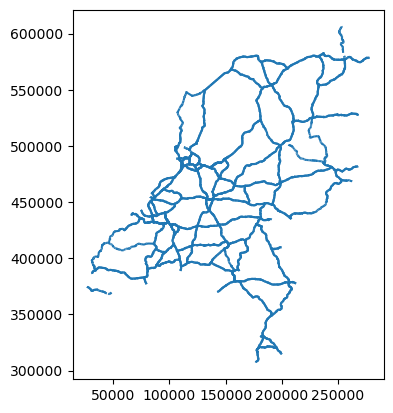

In [3]:
highway_shapefile = 'Shapefiles/Snelheid_Wegvakken.shp'
network = gpd.read_file(highway_shapefile)
network.plot()

In [4]:
data = pd.read_csv('incidents_clean.csv')
for i in range(len(data)):
    data.loc[i, 'RD_long'], data.loc[i, 'RD_lat'] = WGS84toDutchRD(data.loc[i, 'primaire_locatie_lengtegraad'], 
                                                                   data.loc[i, 'primaire_locatie_breedtegraad'])

In [5]:
data = data[data['RD_long'] > 0]

In [10]:
def plot(ac_type):
    """Plots the heatmap with as parameter the type of incident"""
    if ac_type == "all":
        x = data['RD_long']
        y = data['RD_lat']
    else:
        x = data[data['type'] == ac_type]['RD_long']
        y = data[data['type'] == ac_type]['RD_lat']
    
    resolution = 600 # resolution of the pixels used for the heatmap
    ax = network.plot(color='w', alpha=0.01, figsize=(8,8))
    plt.hist2d(x,y, bins=[np.arange(ax.get_xlim()[0], ax.get_xlim()[1],resolution),
                          np.arange(ax.get_ylim()[0], ax.get_ylim()[1],resolution)],
                         cmap='RdYlGn_r')
    plt.colorbar(ax=ax)
    plt.axis('off')

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(drop)
        plot(drop.value)

Dropdown(description='Incident type', index=3, options=('vehicle_obstruction', 'accident', 'general_obstructio…

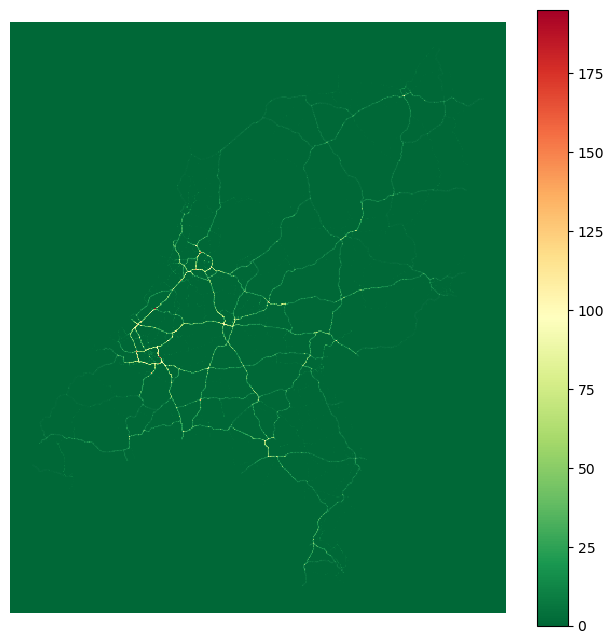

In [11]:
drop = widgets.Dropdown(
    options=['vehicle_obstruction', 'accident', 'general_obstruction', 'all'],
    value='all',
    description='Incident type')

plot("all")
display(drop)
drop.observe(on_change)